# ASML Stock Return & Volatility Explorer + ML Baseline

End-to-end financial data science pipeline:
EDA → cleaning → feature engineering → visualization → ML baseline → evaluation.

Asset: ASML.AS (Euronext Amsterdam)
Period: 2010–2025
Target: predict whether next 5-day return is positive.


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volatility import BollingerBands

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Optional but nice for ACF
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams["figure.figsize"] = (12,4)


In [23]:
ticker = "ASML.AS"
start = "2010-01-01"
end   = "2025-01-01"

df = yf.download(ticker, start=start, end=end)
df

C:\Users\Borja\AppData\Local\Temp\ipykernel_10952\323149090.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,ASML.AS,ASML.AS,ASML.AS,ASML.AS,ASML.AS
Date,,,,,
2010-01-04,26.904173,26.970713,26.493846,26.504936,1563947
2010-01-05,26.954073,27.308949,26.682370,26.743362,1550318
2010-01-06,27.242420,27.242420,26.815458,26.843182,1133902
2010-01-07,26.743372,27.114886,26.394040,27.114886,2648723
2010-01-08,25.845083,26.710098,25.811813,26.615833,3064292
...,...,...,...,...,...
2024-12-23,677.205200,683.048323,671.758244,673.838027,527957
2024-12-24,681.859924,684.137730,679.086940,683.444469,116531


In [24]:
df = df.sort_index()
df = df[~df.index.duplicated(keep="first")]

print(df.isna().sum())
print(df.shape)


Price   Ticker 
Close   ASML.AS    0
High    ASML.AS    0
Low     ASML.AS    0
Open    ASML.AS    0
Volume  ASML.AS    0
dtype: int64
(3840, 5)


## 1. EDA — Price & Returns


In [ ]:
df.columns = df.columns.get_level_values(0)
df

Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,26.904173,26.970713,26.493846,26.504936,1563947
2010-01-05,26.954073,27.308949,26.682370,26.743362,1550318
2010-01-06,27.242420,27.242420,26.815458,26.843182,1133902
2010-01-07,26.743372,27.114886,26.394040,27.114886,2648723
2010-01-08,25.845083,26.710098,25.811813,26.615833,3064292
...,...,...,...,...,...
2024-12-23,677.205200,683.048323,671.758244,673.838027,527957
2024-12-24,681.859924,684.137730,679.086940,683.444469,116531
2024-12-27,678.294678,688.891436,673.441910,674.531278,532668


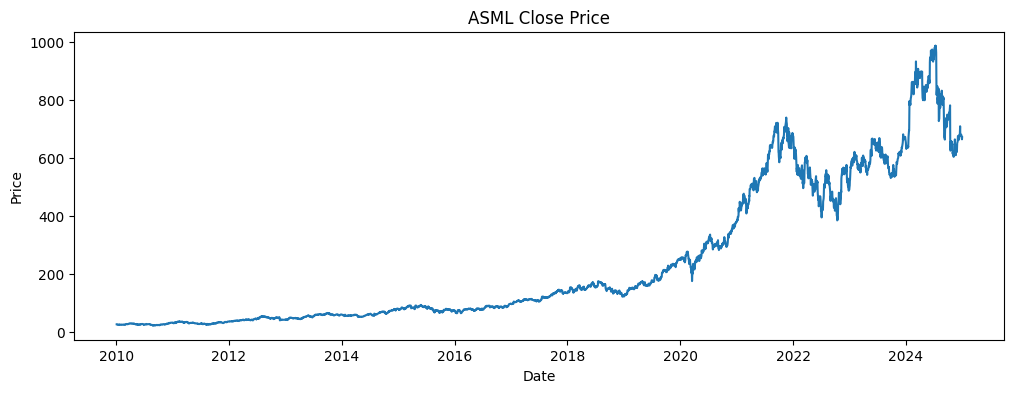

In [30]:
plt.plot(df.index, df["Close"])
plt.title("ASML Close Price")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()


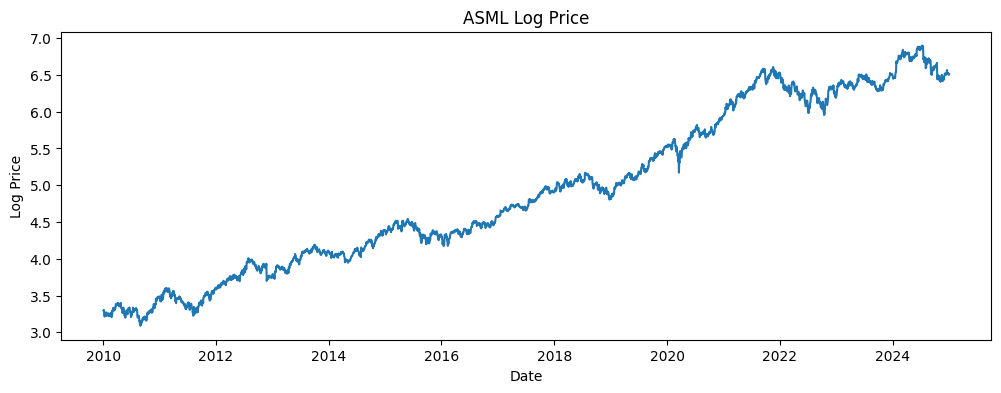

In [31]:
plt.plot(df.index, np.log(df["Close"]))
plt.title("ASML Log Price")
plt.xlabel("Date"); plt.ylabel("Log Price")
plt.show()


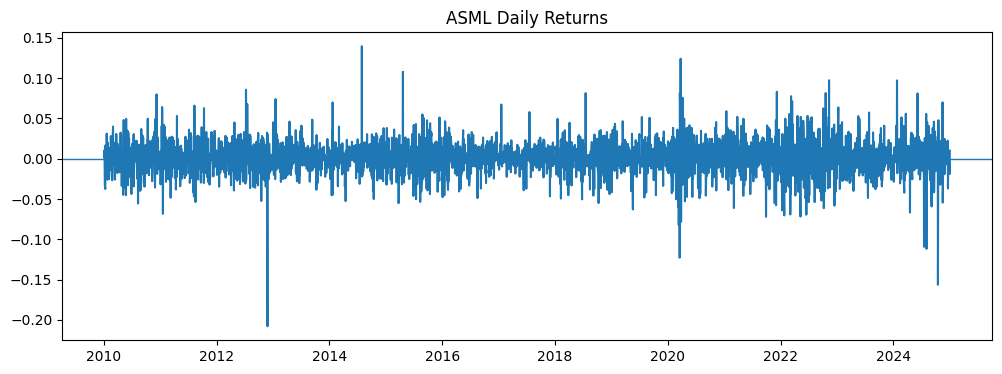

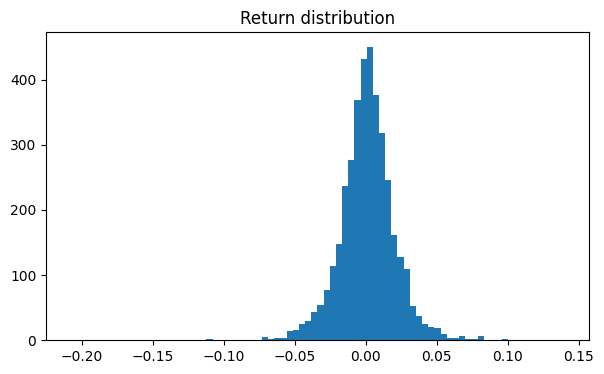

count    3839.000000
mean        0.001042
std         0.020142
min        -0.207988
25%        -0.009522
50%         0.001289
75%         0.011876
max         0.139550
Name: daily_ret, dtype: float64

In [32]:
df["daily_ret"] = df["Close"].pct_change()

plt.plot(df.index, df["daily_ret"])
plt.axhline(0, linewidth=1)
plt.title("ASML Daily Returns")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(df["daily_ret"].dropna(), bins=80)
plt.title("Return distribution")
plt.show()

df["daily_ret"].describe()


In [36]:
# Calculate daily volatility (std of daily returns)
daily_vol = df["daily_ret"].std()

# Annualise volatility
annual_vol = daily_vol * np.sqrt(252)

print(f"Daily volatility: {daily_vol:.4f} ({daily_vol*100:.2f}%)")
print(f"Annualised volatility: {annual_vol:.4f} ({annual_vol*100:.2f}%)")


Daily volatility: 0.0201 (2.01%)
Annualised volatility: 0.3197 (31.97%)


ASML es un activo volátil, pero dentro de rangos habituales para empresas tecnológicas globales.

La acción puede tener movimientos diarios visibles (+/-2%), pero los movimientos anuales grandes (+/-30%) son completamente normales y esperados.

Esta volatilidad refleja tanto el crecimiento del sector como la sensibilidad de ASML a ciclos tecnológicos, macroeconómicos y de mercado.

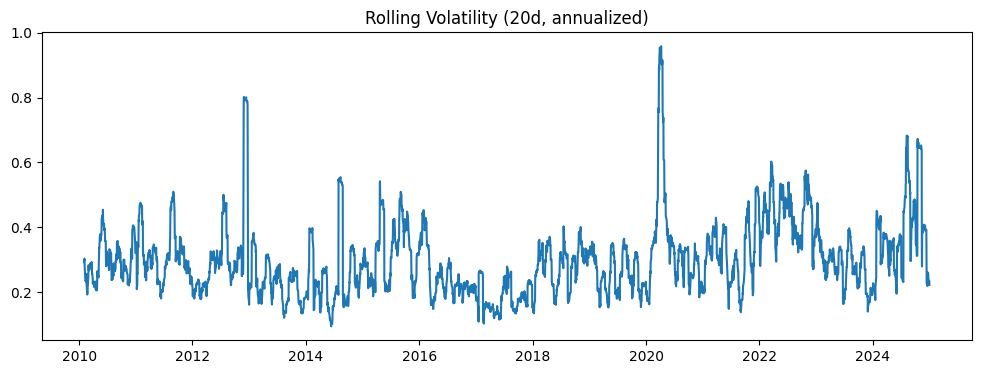

In [37]:
df["vol20"] = df["daily_ret"].rolling(20).std() * np.sqrt(252)

plt.plot(df.index, df["vol20"])
plt.title("Rolling Volatility (20d, annualized)")
plt.show()


Rolling 20-day volatility estimates how risky ASML has been in the past month, and then annualises that estimate so it can be compared to yearly risk levels.

👉 los retornos no son IID
👉 la varianza no es constante (heteroscedasticidad)
👉 hay clustering de volatilidad, propio de activos financieros reales

Por eso modelos como GARCH existen.

4. ASML es más volátil durante shocks macro que durante shocks propios

Esto es importante:

Los picos máximos no coinciden con resultados de ASML,

sino con eventos globales o de mercado.

Conclusión profesional:

👉 La volatilidad de ASML está dominada por riesgo sistémico, no por riesgo idiosincrático.


Valores típicos que se ven en el gráfico:

Mínimos: ~0.15 → muy tranquilo

Normales: 0.25–0.40 → rango común

Elevados: 0.40–0.60 → tensión/pánico moderado

Extremos: 0.8–1.0 → crisis (COVID)

Esto encaja con:

👉 acciones de megacap tecnológicas (Nvidia, ASML, etc.)
👉 ciclos del mercado de semiconductores
👉 sensibilidad a tipos, crecimiento y supply chain

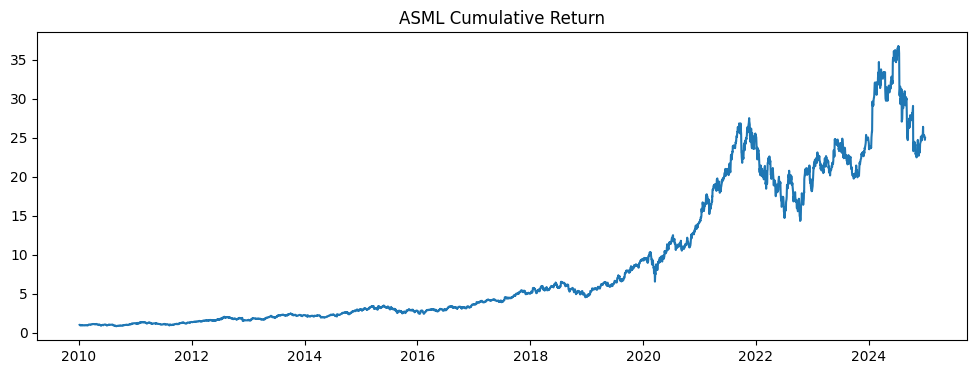

In [38]:
df["cumulative_ret"] = (1 + df["daily_ret"]).cumprod()

plt.plot(df.index, df["cumulative_ret"])
plt.title("ASML Cumulative Return")
plt.show()


The cumulative return chart shows that ASML has been an extraordinary long-term compounder, turning 1 euro invested in 2010 into more than 30 euros by 2024 (+3000%).
Growth has come in waves, with sharp upward movements followed by significant corrections, indicating high volatility but strong long-term momentum.
The trend is clearly upward, but the path is far from smooth, reflecting the cyclical and technology-driven nature of the semiconductor industry.

In [47]:
# fijar valor inicial correctamente sin warnings
df.loc[df.index[0], "cumulative_ret"] = 1

initial_value = df["cumulative_ret"].iloc[0]
final_value   = df["cumulative_ret"].iloc[-1]

n_years = len(df) / 252

cagr = (final_value / initial_value)**(1 / n_years) - 1

print(f"CAGR: {cagr:.4f} ({cagr*100:.2f}%)")


CAGR: 0.2352 (23.52%)


Durante los últimos 3840 días (~15.24 años):

ASML ha generado un retorno compuesto del 23.5% anual [compound anual growth rate (CAGR).]

Esto es más del doble del rendimiento histórico del mercado.

Muy pocas empresas del mundo mantienen un CAGR >20% por más de una década.

ASML está literalmente en el top 1% de acciones globales en cuanto a crecimiento sostenido.

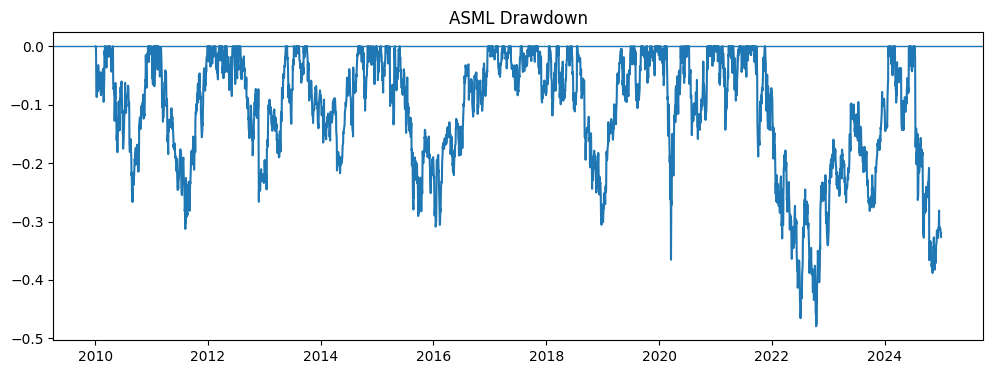

In [39]:
df["cummax"] = df["Close"].cummax()
df["drawdown"] = df["Close"] / df["cummax"] - 1

plt.plot(df.index, df["drawdown"])
plt.title("ASML Drawdown")
plt.axhline(0, linewidth=1)
plt.show()


Un drawdown mide cuánto ha caído tu inversión desde su último pico.

Es la forma más importante de medir riesgo y dolor del inversor.

Ejemplos:

-0.20 → caída del 20% desde máximos

-0.35 → caída del 35%

-0.50 → caída del 50%

El máximo drawdown es la peor caída histórica.

The drawdown chart shows that, despite ASML’s exceptional long-term performance, the stock regularly experiences deep corrections of 20–40%.
Major crises (2011–12, 2018, COVID-2020, and 2022) resulted in drawdowns exceeding 30–45%.
ASML delivers high returns but with significant interim risk, highlighting its high-beta, cyclical nature

El Calmar Ratio

(CAGR dividido entre |MDD| → indicador profesional de calidad del riesgo)

Tu ratio sería aproximadamente:


0.235/
0.479
≈
0.49

Que es:

bueno (cerca de 0.5)

típico de una acción tech de calidad

mejor que la mayoría del mercado

In [50]:
df["drawdown"].min()

np.float64(-0.47932908053337)

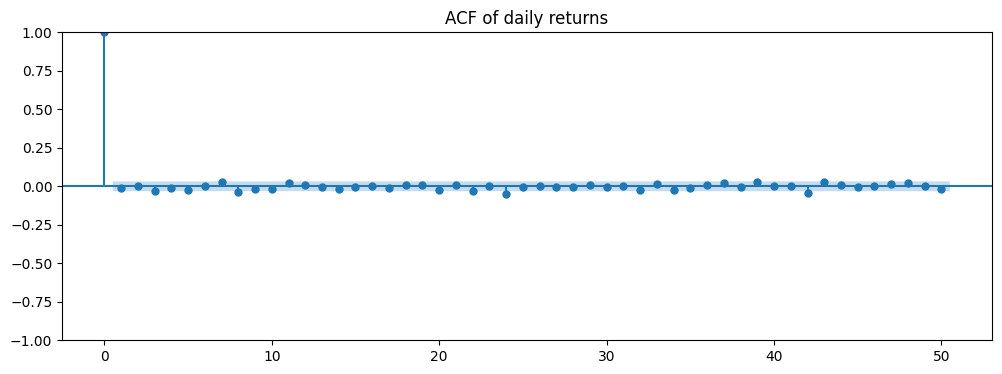

In [40]:
plot_acf(df["daily_ret"].dropna(), lags=50)
plt.title("ACF of daily returns")
plt.show()
